In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob
from math import sqrt

In [2]:
def compute_stats_range(x_vals, y_vals, x_stds):
    ### computes statistic intervals given x, y and x uncertainties.
    r, p_ignore = scipy.stats.pearsonr(x_vals, y_vals)
    mue = mean_absolute_error(x_vals, y_vals)
    rmse = mean_squared_error(x_vals, y_vals)
    rho, p_ignore = scipy.stats.spearmanr(x_vals, y_vals)
    tau, p_ignore = scipy.stats.kendalltau(x_vals, y_vals)
    
 
    # compute the higher bound for x using the standard deviation:
    upper_x_vals = []
    for x, y, std in zip(x_vals, y_vals, x_stds):
        if x <= y:
            upper_x = x-std
        elif x > y:
            upper_x = x + std
        upper_x_vals.append(upper_x)

    # with this new array, compute stats side by side and subtract to get the uncertainty:
    upper_r, p_ignore = scipy.stats.pearsonr(upper_x_vals, y_vals)
    r_range = r - upper_r      

    upper_mue = mean_absolute_error(upper_x_vals, y_vals)
    mue_range = upper_mue - mue

    upper_rmse = sqrt(mean_squared_error(upper_x_vals, y_vals))
    rmse_range = upper_rmse - rmse

    upper_rho, p_ignore = scipy.stats.spearmanr(upper_x_vals, y_vals)
    rho_range = rho - upper_rho

    upper_tau, p_ignore = scipy.stats.kendalltau(upper_x_vals, y_vals)
    tau_range = tau - upper_tau

    results = [ r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range ]
   
    return results

In [3]:
def compute_stats(x_vals, y_vals):
    ### computes single-point statistic intervals
    r, p_ignore = scipy.stats.pearsonr(x_vals, y_vals)
    mue = mean_absolute_error(x_vals, y_vals)
    rmse = mean_squared_error(x_vals, y_vals)
    rho, p_ignore = scipy.stats.spearmanr(x_vals, y_vals)
    tau, p_ignore = scipy.stats.kendalltau(x_vals, y_vals)
    results = [ r, mue, rmse, rho, tau ]
   
    return results

In [4]:
# load the whole freesolv set:
freesolv_loc = './datasets/backend/freesolv_database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)').sort_index()

freesolv_df

,SMILES,iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem),experimental value (kcal/mol),experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol),experimental reference (original or paper this value was taken from),calculated reference,text notes.
compound id (and file prefix),,,,,,,,,
mobley_1017962,CCCCCC(=O)OC,methyl hexanoate,-2.49,0.6,-3.30,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
mobley_1019269,CCCCO,butan-1-ol,-4.72,0.6,-3.23,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
mobley_1034539,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene",-3.04,0.1,-1.08,0.04,10.1007/s10822-012-9568-8,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
mobley_1036761,C1CCC(CC1)N,cyclohexanamine,-4.59,0.6,-3.95,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
mobley_1046331,c1ccc(cc1)OC=O,phenyl formate,-3.82,0.6,-5.44,0.03,"J. Peter Guthrie, unpublished data, as provide...",10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
...,...,...,...,...,...,...,...,...,...
mobley_9913368,C(=C/Cl)\Cl,"(E)-1,2-dichloroethylene",-0.78,0.6,1.02,0.02,10.1021/ct050097l,10.1021/acs.jced.7b00104,"Renamed mobley_9913368 from (E)-1,2-dichloroet..."
mobley_9942801,CCc1ccc(cc1)C,1-ethyl-4-methyl-benzene,-0.95,0.6,-0.57,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
mobley_994483,CCBr,bromoethane,-0.74,0.6,0.49,0.02,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...


## FreeSolv test set plot

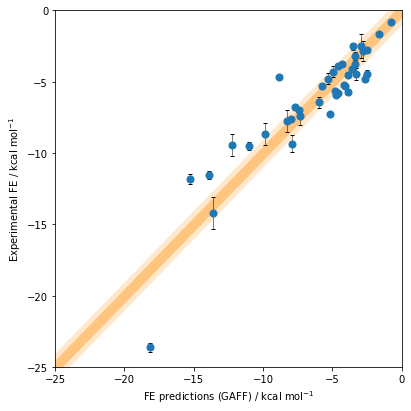

                 Value  Uncertainty
Pearson r     0.919334     0.002971
MUE           1.172927     0.038293
RMSE          2.650476    -0.990759
Spearman rho  0.895858     0.001259
Kendall tau   0.755339     0.001680
Excluding the outlier:
                 Value  Uncertainty
Pearson r     0.928149     0.002499
MUE           1.065750     0.037000
RMSE          1.971448    -0.538457
Spearman rho  0.887847     0.001355
Kendall tau   0.742784     0.001758


In [5]:
# load the whole freesolv set:
freesolv_loc = './datasets/backend/freesolv_database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)').sort_index()

# extract experimental and calculated hydration free energies for just the Wymer et al subset:
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','experimental value (kcal/mol)'].sort_index()
test_calc = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','Mobley group calculated value (GAFF) (kcal/mol)'].sort_index()




# extract associated uncertainties:
test_exp_u = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','experimental uncertainty (kcal/mol)'].sort_index()
test_calc_u = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','calculated uncertainty (kcal/mol)'].sort_index()

# plot the original SAMPL4 predictions:
plt.figure(figsize=(6,6))

plt.errorbar(x=test_calc, y=test_exp, 
             xerr=test_calc_u, yerr=test_exp_u, 
             ls='none', c="black", capsize=2, lw=0.5)

plt.scatter(x=test_calc, y=test_exp, s=50,zorder=100)

# some more formatting:
plt.ylim([-25,0])
plt.xlim([-25,0])
# plt.title("Wymer set FEP vs EXP")
plt.xlabel(r"FE predictions (GAFF) / kcal mol$^{-1}$")
plt.ylabel(r"Experimental FE / kcal mol$^{-1}$")
plt.fill_between(
				x=[-25, 0], 
				y2=[-24.5,0.5],
				y1=[-25.5,-0.5],
				lw=0, 
				zorder=-10,
				alpha=0.5,
				color="darkorange")
# upper bound:
plt.fill_between(
				x=[-25, 0], 
				y2=[-24,1],
				y1=[-24.5,0.5],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-25, 0], 
				y2=[-25.5,-0.5],
				y1=[-26,-1],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)

plt.rcParams.update({'font.size': 16}) 
plt.tight_layout()
plt.savefig("OUTPUTS/wymer_fepVSexp.png", dpi=300)
plt.show()
# statistics:
r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(test_calc, test_exp, test_calc_u)
statistics_wymer = {
                "Pearson r": [r, r_range],
                "MUE": [mue, mue_range],
                "RMSE" : [rmse, rmse_range],
                "Spearman rho" : [rho, rho_range],
                "Kendall tau": [tau, tau_range]        
                   }
statistics_wymer_df = pd.DataFrame.from_dict(statistics_wymer, orient="index", columns=["Value", "Uncertainty"])
print(statistics_wymer_df)
print("Excluding the outlier:")

test_calc_no = test_calc.drop(["mobley_4587267"])
test_exp_no = test_exp.drop(["mobley_4587267"])
test_calc_u_no = test_calc_u.drop(["mobley_4587267"])
r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(test_calc_no, test_exp_no, test_calc_u_no)
statistics_wymer_no = {
                "Pearson r": [r, r_range],
                "MUE": [mue, mue_range],
                "RMSE" : [rmse, rmse_range],
                "Spearman rho" : [rho, rho_range],
                "Kendall tau": [tau, tau_range]        
                   }
statistics_wymer_df_no = pd.DataFrame.from_dict(statistics_wymer_no, orient="index", columns=["Value", "Uncertainty"])
print(statistics_wymer_df_no)

^Note that the FEP predictions have very low uncertainties (~0.03 kcal/mol) and thus don't show up in the plot.

## Apply correction terms
### Load ML models while predicting on test set; take ensemble averages

In [6]:
def correctWymer(dGoffset_predictions, std_dGoffset_predictions, test_calc, test_calc_u, test_exp):
    # correct Wymer FEP predictions in SAMPL4; propagate error by multiplying dGoffset STD with FEP uncertainty.
    wymer_predictions = test_calc.values
    corrected_wymer_predictions = []
    
    # now correct each wymer prediction:
    for offset_pred, wymer_pred in zip(dGoffset_predictions, wymer_predictions):
        corrected = wymer_pred + offset_pred
        corrected_wymer_predictions.append(corrected)
        
    propagated_uncertainties = []
    for ml_error, fep_error in zip(std_dGoffset_predictions, test_calc_u):
        prop_error = sqrt((ml_error**2) + (fep_error**2))
        propagated_uncertainties.append(prop_error)

    stats = compute_stats_range(corrected_wymer_predictions, test_exp, propagated_uncertainties)
    return stats, corrected_wymer_predictions, propagated_uncertainties
    

In [7]:
def loadPredictModels(model_paths, test_X, test_y, corrector=False):
    # loads a list of models (using paths), predicts on test set and generates stats for the ensemble.
    
    # adjust test set structure:
    test_y = [ value[0] for value in test_y.values ] 
       
    # loop over model paths, regenerate, predict:
    predictions = []
    for path in model_paths:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        predictions.append(predicted)
    
    # across predictions, compute mean and std of predictions for each compound:
    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)
    
    if corrector:
        stats, mean_predictions, std_predictions = correctWymer(mean_predictions, std_predictions, test_calc, test_calc_u, test_exp)
    elif not corrector:
        stats = compute_stats_range(mean_predictions, test_y, std_predictions)

    return stats, [mean_predictions, std_predictions]

In [8]:
datasets_dr = "./datasets/DATASETS/"
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

ML_models = ["SVM", "RF", "MLR", "DNN"]

statistics_collection = []
top_performers_collection = []
null_top_performers_collection = []


for ml_model in ML_models:
    
    top_performer_mue = np.inf
    null_top_performer_mue = np.inf
    
    for feature_set in feature_sets:
        # load the corresponding test set files (i.e. with the right features)
        test_X = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index()
        test_y = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()
        
        
        test_X_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index()
        test_y_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()
                
        # now load both the null and corrector models for this feature set:
        model_output_path = ml_model+"/output/"+feature_set
        all_trained_models = glob.glob(model_output_path+"/*.pickle")
        null_models = [model for model in all_trained_models if "null" in model]
        corrector_models = [model for model in all_trained_models if not "null" in model]
        if len(null_models) != len(corrector_models):
            print("NOT THE SAME NUMBER OF CORRECTOR AND NULL MODELS")
        # we will consider all models equal in the ensemble, so each ensemble consists of 5x10 = 50 trained models.
        
        # now for each model, load and predict; extract the necessary data:
        
        stats, prediction = loadPredictModels(corrector_models, test_X, test_y, corrector=True)
        if stats[1] < top_performer_mue:
            top_performer_mue = stats[1]
            top_performer_predictions = prediction
            top_performer_info = feature_set
        
        stats_null, prediction_null = loadPredictModels(null_models, test_X_null, test_y_null)
        if stats_null[1] < null_top_performer_mue:
            null_top_performer_mue = stats_null[1]
            null_top_performer_predictions = prediction_null
            null_top_performer_info = feature_set
            
        statistics_collection.append([ml_model, feature_set, "Corrector", stats])
        statistics_collection.append([ml_model, feature_set, "Null", stats_null])
    # now for this ML model, extract the top performer and its details:
    top_performers_collection.append([ml_model, top_performer_info, top_performer_predictions])
    null_top_performers_collection.append([ml_model, null_top_performer_info, null_top_performer_predictions])
    
# retrieve original FEP statistics to include as first row in table:
wymer_stats = np.append(statistics_wymer_df["Value"].values, statistics_wymer_df["Uncertainty"].values)

def return_merged_w_pm(mean, unc):
    # returns two numbers appended as rounded strings with a plusminus sign between.
    mean = str(round(mean, 2))
    unc = str(round(unc, 2))
    merged_vals = mean+u"\u00B1"+unc
    return merged_vals
    
    
    
stats_df = pd.DataFrame.from_dict([{
        "Model" : "FEP",
        "Featureset" : "",
        "Type" : "",
        "Pearson r" : return_merged_w_pm(wymer_stats[0], wymer_stats[5]),
        "MUE" : return_merged_w_pm(wymer_stats[1], wymer_stats[6]),
        "RMSE" : return_merged_w_pm(wymer_stats[2], wymer_stats[7]),
        "Spearman rho" : return_merged_w_pm(wymer_stats[3], wymer_stats[8]),
        "Kendall tau" : return_merged_w_pm(wymer_stats[4], wymer_stats[9]),
        "r_means" : wymer_stats[0],
        "MUE_means" : wymer_stats[1],
        "RMSE_means" : wymer_stats[2],
        "tau_means" : wymer_stats[4],
        "r_uncs" : wymer_stats[5],
        "MUE_uncs" : wymer_stats[6],
        "RMSE_uncs" : wymer_stats[7],
        "tau_uncs" : wymer_stats[9],
        
    }])           


for model in statistics_collection:
    
    model_stats_dict = {
        "Model" : model[0],
        "Featureset" : model[1],
        "Type" : model[2],
        "Pearson r" : return_merged_w_pm(model[3][0], model[3][5]),
        "MUE" : return_merged_w_pm(model[3][1], model[3][6]),
        "RMSE" : return_merged_w_pm(model[3][2], model[3][7]),
        "Spearman rho" : return_merged_w_pm(model[3][3], model[3][8]),
        "Kendall tau" : return_merged_w_pm(model[3][4], model[3][9]),
        "r_means" : model[3][0],
        "MUE_means" : model[3][1],
        "RMSE_means" : model[3][2],
        "tau_means" : model[3][4],
        "r_uncs" : model[3][5],
        "MUE_uncs" : model[3][6],
        "RMSE_uncs" : model[3][7],
        "tau_uncs" : model[3][9],
    }
    stats_df = stats_df.append(model_stats_dict, ignore_index=True)

stats_df = round(stats_df.sort_values(by=["Type", "MUE_means"]), 3)
stats_df.to_csv("OUTPUTS/SAMPL4_predictions_statistics.csv")


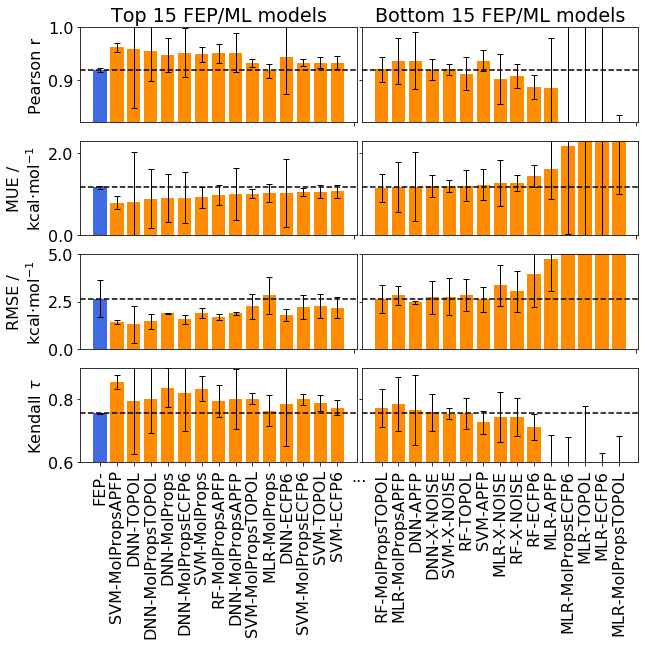

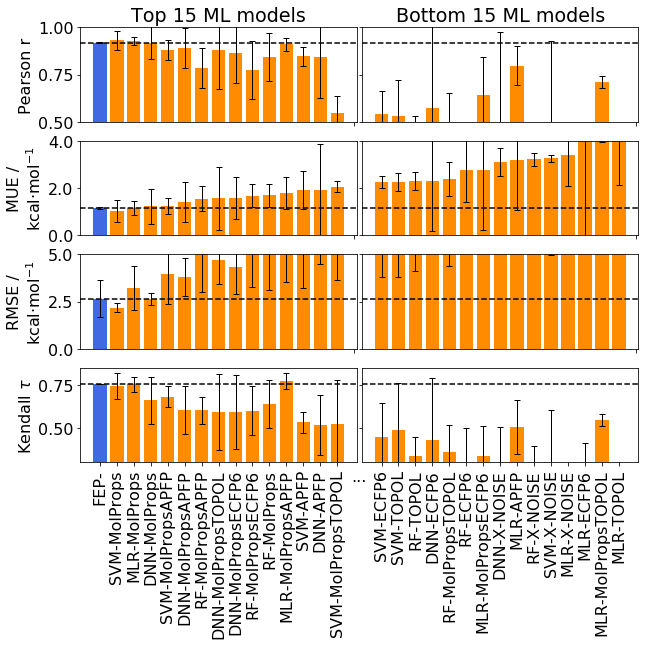

In [9]:
from matplotlib.ticker import FormatStrFormatter

# build a barplot of the above table:
num_bars_per_subplot = 30
num_top = num_bottom = int(num_bars_per_subplot/2)
# divide back into hybrid and PML dataframes:
fep_df = stats_df.loc[stats_df["Model"] == "FEP"]
fep_mean_stats = [fep_df["r_means"].values[0], fep_df["MUE_means"].values[0], fep_df["RMSE_means"].values[0], fep_df["tau_means"].values[0]]

hyb_df = stats_df.loc[stats_df["Type"] == "Corrector"]
pml_df = stats_df.loc[stats_df["Type"] == "Null"]

hyb_plot_data = pd.concat([fep_df, hyb_df], axis=0, ignore_index=True)
hyb_plot_data_top = hyb_plot_data.head(num_top)
hyb_plot_data_bottom = hyb_plot_data.tail(num_bottom)

pml_plot_data = pd.concat([fep_df, pml_df], axis=0, ignore_index=True)
pml_plot_data_top = pml_plot_data.head(num_top)
pml_plot_data_bottom = pml_plot_data.tail(num_bottom)

# define colours (we want FEP to be blue, remainders to be orange):
top_colours = ["royalblue"] + ["darkorange"] * (num_bottom-1)
bottom_colours = ["darkorange"] * num_bottom



def plot_subplot_bars(plotting_data_top, plotting_data_bottom, fep_mean_stats, name):
    # plots a barplot for a selection of sampl4 predictions (either entry 004 hybrid or PML)
    fig, axes = plt.subplots(4, 2, figsize=[10, 8])
    x_labels_top = [model+"-"+featureset for model, featureset in zip(plotting_data_top["Model"], plotting_data_top["Featureset"])]
    x_labels_bottom = [model+"-"+featureset for model, featureset in zip(plotting_data_bottom["Model"], plotting_data_bottom["Featureset"])]
    

    # plot r, mue, rmse and tau with uncertainties:
    axes[0][0].bar(x=x_labels_top, height=plotting_data_top["r_means"], color=top_colours)
    axes[0][0].errorbar(x_labels_top,plotting_data_top["r_means"], yerr=plotting_data_top["r_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[0][0].set_xticks("")
    axes[0][1].bar(x=x_labels_bottom, height=plotting_data_bottom["r_means"], color=bottom_colours)
    axes[0][1].errorbar(x_labels_bottom,plotting_data_bottom["r_means"], yerr=plotting_data_bottom["r_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[0][1].set_xticks("")
    axes[0][1].yaxis.set_major_formatter(plt.NullFormatter())
    ###
    axes[1][0].bar(x=x_labels_top, height=plotting_data_top["MUE_means"], color=top_colours)
    axes[1][0].errorbar(x_labels_top,plotting_data_top["MUE_means"], yerr=plotting_data_top["MUE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[1][0].set_xticks("")
    axes[1][0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[1][1].bar(x=x_labels_bottom, height=plotting_data_bottom["MUE_means"], color=bottom_colours)
    axes[1][1].errorbar(x_labels_bottom,plotting_data_bottom["MUE_means"], yerr=plotting_data_bottom["MUE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[1][1].set_xticks("")
    axes[1][1].yaxis.set_major_formatter(plt.NullFormatter())
    ###
    axes[2][0].bar(x=x_labels_top, height=plotting_data_top["RMSE_means"], color=top_colours)
    axes[2][0].errorbar(x_labels_top,plotting_data_top["RMSE_means"], yerr=plotting_data_top["RMSE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[2][0].set_xticks("")    
    axes[2][1].bar(x=x_labels_bottom, height=plotting_data_bottom["RMSE_means"], color=bottom_colours)
    axes[2][1].errorbar(x_labels_bottom,plotting_data_bottom["RMSE_means"], yerr=plotting_data_bottom["RMSE_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[2][1].set_xticks("")
    axes[2][1].yaxis.set_major_formatter(plt.NullFormatter())
    ###
    axes[3][0].bar(x=x_labels_top, height=plotting_data_top["tau_means"], color=top_colours)
    axes[3][0].errorbar(x_labels_top,plotting_data_top["tau_means"], yerr=plotting_data_top["tau_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[3][0].set_xticklabels(x_labels_top, rotation=90)
    axes[3][1].bar(x=x_labels_bottom, height=plotting_data_bottom["tau_means"], color=bottom_colours)
    axes[3][1].errorbar(x_labels_bottom,plotting_data_bottom["tau_means"], yerr=plotting_data_bottom["tau_uncs"], capsize=3, elinewidth=1, markeredgewidth=1, fmt="none", color="black")
    axes[3][1].set_xticklabels(x_labels_bottom, rotation=90)
    axes[3][1].yaxis.set_major_formatter(plt.NullFormatter())   
    
    # formatting and plot:
    for r_ax in [axes[0][0], axes[0][1]]:
        if name == "FEP/ML":
            r_ax.set_ylim(0.82,1)
        elif name == "ML":
            r_ax.set_ylim(0.5,1)
        r_ax.axhline(fep_mean_stats[0], color="black", ls="--")
    
    for mue_ax in [axes[1][0], axes[1][1]]:
        if name == "FEP/ML":
            mue_ax.set_ylim(0,2.3)
        elif name == "ML":
            mue_ax.set_ylim(0,4)
        mue_ax.axhline(fep_mean_stats[1], color="black", ls="--")
        
    for rmse_ax in [axes[2][0], axes[2][1]]:
        if name == "FEP/ML":
            rmse_ax.set_ylim(0,5)
        elif name == "ML":
            rmse_ax.set_ylim(0,5)
        rmse_ax.axhline(fep_mean_stats[2], color="black", ls="--")
    
    for tau_ax in [axes[3][0], axes[3][1]]:
        if name == "FEP/ML":
            tau_ax.set_ylim(0.6,0.9)
        elif name == "ML":
            tau_ax.set_ylim(0.3,0.85)
        tau_ax.axhline(fep_mean_stats[3], color="black", ls="--")

    axes[0][0].set_ylabel("Pearson r")
    axes[1][0].set_ylabel("MUE /\nkcal$\cdot$mol$^{-1}$")
    axes[2][0].set_ylabel("RMSE /\nkcal$\cdot$mol$^{-1}$")
    axes[3][0].set_ylabel(r"Kendall $\tau$")
    
    axes[0][0].set_title("Top "+str(num_top)+" "+name+" models")
    axes[0][1].set_title("Bottom "+str(num_top)+" "+name+" models")
    
    plt.subplots_adjust(wspace = 0.02)
    plt.text(s="...", x=0.98, y=-1.4, transform=axes[2][0].transAxes)
    if name == "FEP/ML":
        name = "FEP-ML"
    plt.savefig("OUTPUTS/sampl4_"+name+"_stats_bars.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_subplot_bars(hyb_plot_data_top, hyb_plot_data_bottom, fep_mean_stats, name="FEP/ML")

plot_subplot_bars(pml_plot_data_top, pml_plot_data_bottom, fep_mean_stats, name="ML")


### Process top performers per ML model; generate detailed plots

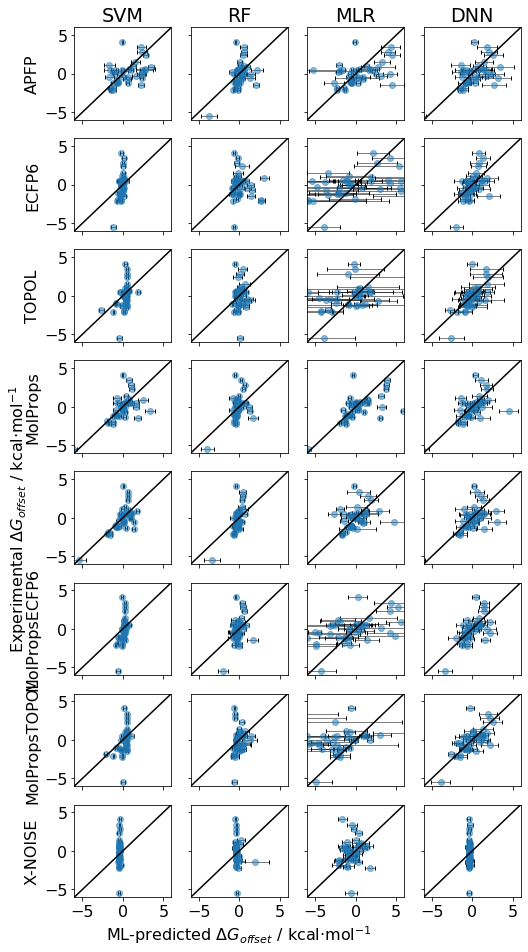

In [10]:
# first plot dGoffset scatterplots (predicted vs exp):
# ML_models = ["SVM"]
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

ML_models = ["SVM", "RF", "MLR", "DNN"]

data_iterator = []
for feature_set in feature_sets:
    for ml_model in ML_models:
        data_iterator.append([feature_set, ml_model])
        
  
fig, axes = plt.subplots(8, 4, sharey=True, sharex=True, figsize=[8, 16])

# do some formatting on the axes:
for ax, ml_model in zip(axes.flat[0:4], ML_models):
    ax.set_title(ml_model)
    
subplots_for_ylabel = [0, 4, 8, 12, 16, 20, 24, 28]    
for ax, feature_set in zip(axes.flat[subplots_for_ylabel], feature_sets):
    ax.set_ylabel(feature_set)
      
# use the data selection nested list to loop over a flat array of axes:
for ax, data_selection in zip(axes.flat, data_iterator):

    feature_set = data_selection[0]
    ml_model = data_selection[1]
    # load the corresponding test set files (i.e. with the right features)
    test_X = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index()
    test_y = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index()


    # now load both the null and corrector models for this feature set:
    model_output_path = ml_model+"/output/"+feature_set
    all_trained_models = glob.glob(model_output_path+"/*.pickle")
    corrector_models = [model for model in all_trained_models if not "null" in model]

    # now for each model, load and predict; extract the necessary data:

    predictions = []
    for path in corrector_models:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        predictions.append(predicted)

    # across predictions, compute mean and std of predictions for each compound:
    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)

    ax.scatter(mean_predictions, test_y["dGoffset (kcal/mol)"].values, label=feature_set, alpha=0.5)
    ax.errorbar(x=mean_predictions, y=test_y["dGoffset (kcal/mol)"].values, 
             xerr=std_predictions, 
             ls='none', c="black", capsize=2, lw=0.5, zorder=-100)
    ax.plot((-100, 100),(-100, 100),color="black")
    ax.set_ylim(-6,6)
    ax.set_xlim(-6,6)
    
axes.flat[29].set_xlabel(r"ML-predicted $\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$")
axes.flat[16].set_ylabel(r"Experimental $\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$", labelpad=15)

plt.rcParams.update({'font.size': 18})

plt.savefig("OUTPUTS/sampl4_offset_predictions_ALL.png", dpi=300)

plt.show()

SVM
r: 0.687931628356466 +- 0.07534699538909395
mue: 0.7963548119107658 +- 0.16420747159066396
tau: 0.4585365853658536 +- 0.07560975609756099
RF
r: 0.6901836184759199 +- 0.3048536354621087
mue: 0.9856868821478915 +- 0.23452356407142605
tau: 0.3878048780487805 +- 0.32439024390243903
MLR
r: 0.6185485437968934 +- 0.026032047575807238
mue: 1.0270074757420222 +- 0.2211629738651728
tau: 0.47804878048780486 +- 0.06829268292682927
DNN
r: 0.7159162929513843 +- 0.6732565555838036
mue: 0.8098785122677675 +- 1.2173295854907966
tau: 0.5317073170731708 +- 0.5195121951219512


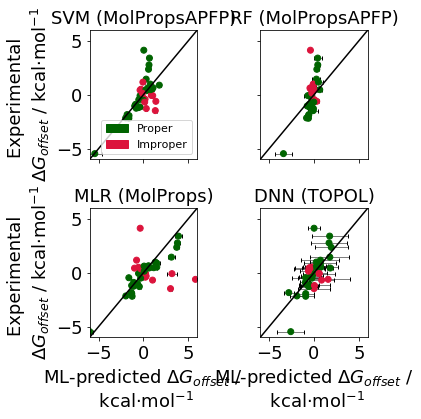

In [11]:
# now make plots of only the top performers to put in main text:

# retrieve data for plotting:
wymer_predictions = test_calc
wymer_uncertainties = test_calc_u
exp_values = test_exp
exp_uncertainties = test_exp_u

# we want to make a scatterplot for each ML model with overlays of corrected and null predictions:
fig, axes = plt.subplots(2, 2, sharey=True,sharex=True, figsize=[6, 6])

stats_collection = []
# join the data together with the axes, plot per ml model:

for corrector, null, ax in zip(top_performers_collection, null_top_performers_collection, axes.flat):

    model_name = corrector[0]
    feature_set = corrector[1]

    corrected_predictions = corrector[2][0]
    corrected_uncertainties = corrector[2][1]
    
    ax.set_title(model_name+" ("+feature_set+")", fontsize="medium")
    predicted_dGoffsets = []
    exp_dGoffsets = []
    
    # now extract the corrections:
    colours = []
    for corrected, fep, exp in zip(corrected_predictions, wymer_predictions, exp_values):
        
        # compute the subtracted offset (i.e. the correction that was applied):
        predicted_offset =  corrected - fep
        predicted_dGoffsets.append(predicted_offset)
        # compute the real offset (that we were trying to predict):
        fep_real_offset = exp - fep
        exp_dGoffsets.append(fep_real_offset)
        # derive colours; if both predicted and exp offset are positive or negative, we have a proper direction, if not it's improper:
        if predicted_offset > 0 and fep_real_offset > 0:
            colours.append("darkgreen")
        elif predicted_offset < 0 and fep_real_offset < 0:
            colours.append("darkgreen")
        else:
            colours.append("crimson")
        
    ax.scatter(predicted_dGoffsets, exp_dGoffsets, color=colours)
    ax.plot((-100, 100),(-100, 100),color="black")
    ax.errorbar(predicted_dGoffsets, exp_dGoffsets, xerr=corrected_uncertainties, ls="none", color="black", zorder=-100, capsize=2, lw=0.5)
    ax.set_ylim(-6,6)
    ax.set_xlim(-6,6)
    # finally, compute stats:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(predicted_dGoffsets, exp_dGoffsets, corrected_uncertainties)
    stats_collection.append([model_name, r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range])
    
axes[0][0].set_ylabel("Experimental \n$\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_ylabel("Experimental \n$\Delta G_{offset}$ / kcal$\cdot$mol$^{-1}$")

axes[1][0].set_xlabel("ML-predicted $\Delta G_{offset}$ / \n kcal$\cdot$mol$^{-1}$")
axes[1][1].set_xlabel("ML-predicted $\Delta G_{offset}$ / \n kcal$\cdot$mol$^{-1}$")


plt.rcParams.update({'font.size': 14}) 

for stat in stats_collection:
    print(stat[0])
    print("r:", stat[1], "+-", stat[6])
    print("mue:", stat[2], "+-", stat[7])
    print("tau:", stat[5], "+-", stat[10])
    
    
plt.tight_layout()
# make a custom legend:
import matplotlib.patches as mpatches
proper_corr_patch = mpatches.Patch(color='darkgreen', label='Proper')
improper_corr_patch = mpatches.Patch(color='crimson', label='Improper')
axes[0][0].legend(handles=[proper_corr_patch, improper_corr_patch], loc="lower right", prop={'size': 11})


plt.savefig("OUTPUTS/sampl4_offset_predictions_topperformers.png", dpi=300)
plt.show()

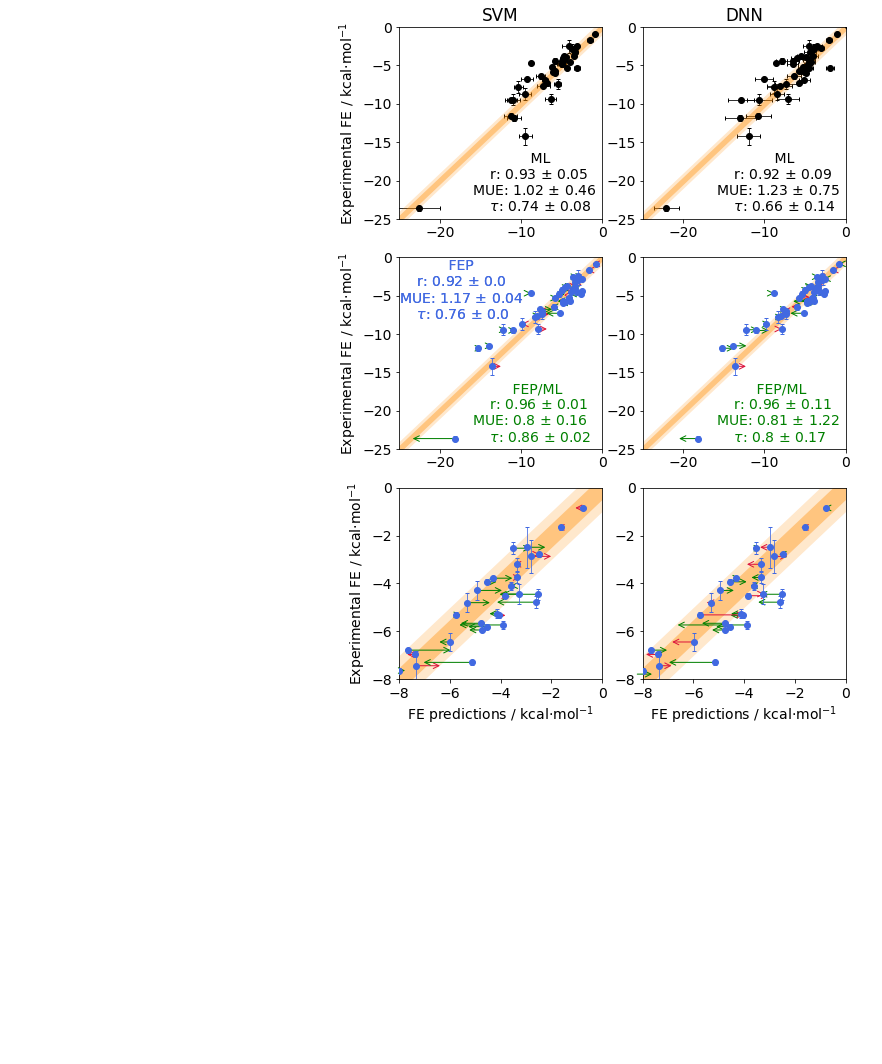

In [12]:
# we want to make a scatterplot for each ML model with overlays of corrected and null predictions:
fig, axes = plt.subplots(3, 2, figsize=[8, 12])

# plot only SVM and DNN:
top_performers_collection_selection = [top_performers_collection[0], top_performers_collection[3]]
null_top_performers_collection_selection = [null_top_performers_collection[0], null_top_performers_collection[3]]

# join the data together with the axes, plot per ml model:
for corrector, null, col in zip(top_performers_collection_selection, null_top_performers_collection_selection, [0, 1]):
    model_name = null[0]
    feature_set_null = null[1]
    predictions_null = null[2][0]
    uncertainties_null = null[2][1]
    corrected_predictions = corrector[2][0]
    corrected_uncertainties = corrector[2][1]
    
    ###########################
    # first, plot the null predictions on the first column:
    axes[0][col].scatter(predictions_null, exp_values, color="black")
    axes[0][col].errorbar(predictions_null, exp_values, 
                xerr=uncertainties_null, yerr=exp_uncertainties, 
                color="black", ls='none', capsize=2, lw=0.8, zorder=-100)
    axes[0][col].set_xlim(-25,0)
    axes[0][col].set_ylim(-25,0)
    # compute stats for ML and annotate:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(predictions_null, exp_values, uncertainties_null)
    r_string = ("    r: "+str(round(r, 2))+r" $\pm$ "+str(round(r_range, 2)))
    mue_string = ("MUE: "+str(round(mue, 2))+r" $\pm$ "+str(round(mue_range, 2)))
    tau_string = (r"    $\tau$: "+str(round(tau, 2))+r" $\pm$ "+str(round(tau_range, 2)))
    stats_string = "             ML\n"+r_string + "\n" + mue_string + "\n" + tau_string
    axes[0][col].annotate(s=stats_string, xy=(-16,-24))
    ############################
    # now plot the FEP predictions on the second column:
    def plot_scatter_with_arrow_corrections(row, lower_bound):
        axes[row][col].scatter(wymer_predictions, exp_values, color="royalblue", zorder=200)
        axes[row][col].errorbar(wymer_predictions, exp_values, 
                    xerr=wymer_uncertainties, yerr=exp_uncertainties, 
                    color="royalblue", ls='none', capsize=2, lw=0.8, zorder=200)

        # now plot the corrections. First, extract the actual correction values:
        for corrected, fep, exp in zip(corrected_predictions, wymer_predictions, exp_values):

            # compute the remaining offset after correction:
            corrected_offset = exp - corrected
            # compute the real offset (that we were trying to predict):
            fep_real_offset = fep - exp

            # if the remaining offset is smaller than the real offset, the correction has been beneficial:
            if abs(corrected_offset) <= abs(fep_real_offset):
                line_color = "green"
            else:
                line_color = "crimson"

            # exclude small corrections for formatting:
            if abs(corrected) >= 0.1:
                # draw the arrows:
                axes[row][col].annotate("", xytext=(fep, exp), xy=(corrected, exp), 
                    arrowprops=dict(arrowstyle="->", color=line_color, label="Correction")
                    )
        axes[row][col].set_xlim(lower_bound,0)
        axes[row][col].set_ylim(lower_bound,0)
    plot_scatter_with_arrow_corrections(row=1, lower_bound=-25)
    # compute stats for FEP and annotate:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(wymer_predictions, exp_values, wymer_uncertainties)
    r_string = ("    r: "+str(round(r, 2))+r" $\pm$ "+str(round(r_range, 2)))
    mue_string = ("MUE: "+str(round(mue, 2))+r" $\pm$ "+str(round(mue_range, 2)))
    tau_string = (r"    $\tau$: "+str(round(tau, 2))+r" $\pm$ "+str(round(tau_range, 2)))
    stats_string = "           FEP\n" +r_string + "\n" + mue_string + "\n" + tau_string
    axes[1][0].annotate(s=stats_string, xy=(-25,-8), color="royalblue")
    # compute stats for FEP/ML and annotate:
    r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = compute_stats_range(corrected_predictions, exp_values, corrected_uncertainties)
    r_string = ("    r: "+str(round(r, 2))+r" $\pm$ "+str(round(r_range, 2)))
    mue_string = ("MUE: "+str(round(mue, 2))+r" $\pm$ "+str(round(mue_range, 2)))
    tau_string = (r"    $\tau$: "+str(round(tau, 2))+r" $\pm$ "+str(round(tau_range, 2)))
    stats_string = "         FEP/ML\n"+r_string + "\n" + mue_string + "\n" + tau_string
    axes[1][col].annotate(s=stats_string, xy=(-16,-24), color="green")
    ############################
    # now plot the FEP predictions again but zoomed in on the third column:    
    plot_scatter_with_arrow_corrections(row=2, lower_bound=-8)

    
  
# do some formatting on the axes:
for i, ax in enumerate(fig.axes):
    ax.set_xlabel(r"FE predictions / kcal$\cdot$mol$^{-1}$")
    
    ax.fill_between(
				x=[-25, 0], 
				y2=[-24.5,0.5],
				y1=[-25.5,-0.5],
				lw=0, 
				zorder=-10,
				alpha=0.5,
				color="darkorange")
    # upper bound:
    ax.fill_between(
				x=[-25, 0], 
				y2=[-24,1],
				y1=[-24.5,0.5],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)
    # lower bound:
    ax.fill_between(
				x=[-25, 0], 
				y2=[-25.5,-0.5],
				y1=[-26,-1],
				lw=0, 
				zorder=-10,
				color="darkorange", 
				alpha=0.2)
    
    
axes[0][0].set_ylabel(r"Experimental FE / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_ylabel(r"Experimental FE / kcal$\cdot$mol$^{-1}$")
axes[2][0].set_ylabel(r"Experimental FE / kcal$\cdot$mol$^{-1}$")

axes[0][0].set_xlabel("")
axes[0][1].set_xlabel("")
axes[1][0].set_xlabel("")
axes[1][1].set_xlabel("")

axes[0][0].set_title("SVM")
axes[0][1].set_title("DNN")



plt.rcParams.update({'font.size': 14})
plt.savefig("OUTPUTS/sampl4_correction_scatterplots.png", dpi=300)



plt.show()

The outlier (mobley_4587267, ~-23 kcal/mol) seems to influence model performance substancially. Let's regenerate the performance table while excluding this datapoint:

In [13]:
def loadPredictModels(model_paths, test_X, test_y, corrector=False):
    # loads a list of models (using paths), predicts on test set and generates stats for the ensemble.
    
    # adjust test set structure:
    test_y = [ value[0] for value in test_y.values ] 
       
    # loop over model paths, regenerate, predict:
    predictions = []
    for path in model_paths:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        predicted = model.predict(test_X)
        predictions.append(predicted)
    
    # across predictions, compute mean and std of predictions for each compound:
    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)
    
    if corrector:
        stats, mean_predictions, std_predictions = correctWymer(mean_predictions, std_predictions, test_calc.drop("mobley_4587267"), test_calc_u.drop("mobley_4587267"), test_exp.drop("mobley_4587267"))
    elif not corrector:
        stats = compute_stats_range(mean_predictions, test_y, std_predictions)

    return stats, [mean_predictions, std_predictions]


datasets_dr = "./datasets/DATASETS/"
feature_sets = ["APFP", "ECFP6", "TOPOL", "MolProps", "MolPropsAPFP", "MolPropsECFP6", "MolPropsTOPOL", "X-NOISE"]

ML_models = ["SVM", "RF", "MLR", "DNN"]


statistics_collection_no_outlier = []
top_performers_collection_no_outlier = []
null_top_performers_collection_no_outlier = []


for ml_model in ML_models:
    
    top_performer_mue = np.inf
    null_top_performer_mue = np.inf
    
    for feature_set in feature_sets:
        # load the corresponding test set files (i.e. with the right features)
        test_X = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index().drop("mobley_4587267")
        test_y = pd.read_csv(datasets_dr + "test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index().drop("mobley_4587267")
                
        
        test_X_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,:-2].sort_index().drop("mobley_4587267")
        test_y_null = pd.read_csv(datasets_dr + "null_test_"+feature_set+'.csv', index_col='ID').iloc[:,-2:-1].sort_index().drop("mobley_4587267")
        
        
        # now load both the null and corrector models for this feature set:
        model_output_path = ml_model+"/output/"+feature_set
        all_trained_models = glob.glob(model_output_path+"/*.pickle")
        null_models = [model for model in all_trained_models if "null" in model]
        corrector_models = [model for model in all_trained_models if not "null" in model]
        if len(null_models) != len(corrector_models):
            print("NOT THE SAME NUMBER OF CORRECTOR AND NULL MODELS")
        # we will consider all models equal in the ensemble, so each ensemble consists of 5x10 = 50 trained models.
        
        # now for each model, load and predict; extract the necessary data:
        
        stats, prediction = loadPredictModels(corrector_models, test_X, test_y, corrector=True)
        if stats[1] < top_performer_mue:
            top_performer_mue = stats[1]
            top_performer_predictions = prediction
            top_performer_info = feature_set
        
        stats_null, prediction_null = loadPredictModels(null_models, test_X_null, test_y_null)
        if stats_null[1] < null_top_performer_mue:
            null_top_performer_mue = stats_null[1]
            null_top_performer_predictions = prediction_null
            null_top_performer_info = feature_set
            
        statistics_collection_no_outlier.append([ml_model, feature_set, "Corrector", stats])
        statistics_collection_no_outlier.append([ml_model, feature_set, "Null", stats_null])
    # now for this ML model, extract the top performer and its details:
    top_performers_collection_no_outlier.append([ml_model, top_performer_info, top_performer_predictions])
    null_top_performers_collection_no_outlier.append([ml_model, null_top_performer_info, null_top_performer_predictions])
    
# retrieve original FEP statistics to include as first row in table:
wymer_stats_no = statistics_wymer_df_no.values

stats_df = pd.DataFrame.from_dict([{
        "Model" : "FEP",
        "Featureset" : "",
        "Type" : "",
        "Pearson r" : return_merged_w_pm(wymer_stats_no[0][0], wymer_stats_no[0][1]),
        "MUE" : return_merged_w_pm(wymer_stats_no[1][0], wymer_stats_no[1][1]),
        "RMSE" : return_merged_w_pm(wymer_stats_no[2][0], wymer_stats_no[2][1]),
        "Spearman rho" : return_merged_w_pm(wymer_stats_no[3][0], wymer_stats_no[3][1]),
        "Kendall tau" : return_merged_w_pm(wymer_stats_no[4][0], wymer_stats_no[4][1]),
    }])           

for model in statistics_collection_no_outlier:
    
    model_stats_dict = {
        "Model" : model[0],
        "Featureset" : model[1],
        "Type" : model[2],
        "Pearson r" : return_merged_w_pm(model[3][0], model[3][5]),
        "MUE" : return_merged_w_pm(model[3][1], model[3][6]),
        "RMSE" : return_merged_w_pm(model[3][2], model[3][7]),
        "Spearman rho" : return_merged_w_pm(model[3][3], model[3][8]),
        "Kendall tau" : return_merged_w_pm(model[3][4], model[3][9]),
        "MUE_means" : model[3][1]
    }

    stats_df = stats_df.append(model_stats_dict, ignore_index=True)

    
pd.options.display.max_rows = 999
stats_df = round(stats_df.sort_values(by=["Type", "MUE_means"]), 3).drop("MUE_means", axis=1)
stats_df.to_csv("OUTPUTS/SAMPL4_predictions_statistics_no_outlier.csv")
stats_df

,Model,Featureset,Type,Pearson r,MUE,RMSE,Spearman rho,Kendall tau
0,FEP,,,0.93±0.0,1.07±0.04,1.97±-0.54,0.89±0.0,0.74±0.0
53,DNN,TOPOL,Corrector,0.94±0.14,0.76±1.21,1.13±1.07,0.92±0.14,0.78±0.18
9,SVM,MolPropsAPFP,Corrector,0.94±0.01,0.82±0.15,1.43±-0.13,0.95±0.01,0.85±0.02
61,DNN,MolPropsTOPOL,Corrector,0.92±0.08,0.88±0.71,1.43±0.39,0.93±0.09,0.79±0.12
59,DNN,MolPropsECFP6,Corrector,0.92±0.06,0.88±0.61,1.49±0.25,0.93±0.1,0.81±0.13
13,SVM,MolPropsTOPOL,Corrector,0.94±0.01,0.91±0.11,1.57±-0.23,0.92±0.01,0.79±0.02
55,DNN,MolProps,Corrector,0.9±0.06,0.92±0.57,1.91±-0.01,0.94±0.04,0.83±0.06
7,SVM,MolProps,Corrector,0.91±0.02,0.93±0.24,1.92±-0.3,0.94±0.02,0.83±0.04
11,SVM,MolPropsECFP6,Corrector,0.94±0.01,0.95±0.09,1.68±-0.31,0.92±0.01,0.79±0.02
25,RF,MolPropsAPFP,Corrector,0.93±0.02,0.96±0.22,1.61±-0.15,0.91±0.03,0.78±0.05


### Insert best ML models into SAMPL4 challenge

In [14]:
def computeTopPerformerStats(collection, entry_name, includes_outlier=True):
    # compute stats in the SAMPL4 format for a given nested list of model predictions.
    collection_sampl4_stats = pd.DataFrame()
    for ml_model_collection in collection:
        ml_model = ml_model_collection[0]
        top_performer_featureset = ml_model_collection[1]
        top_performer_predictions = ml_model_collection[2][0]
        top_performer_uncertainties = ml_model_collection[2][1]
        
        # retrieve the test set of correct size (i.e. with or without the outlier)
        if includes_outlier:
            experimental_values = exp_values
        elif not includes_outlier:
            experimental_values = test_exp
       
        # now compute the stats:
        r, mue, rmse, rho, tau, r_range, mue_range, rmse_range, rho_range, tau_range = \
        compute_stats_range(top_performer_predictions, experimental_values, top_performer_uncertainties)
        
        entry = pd.DataFrame({
                    "R" : r,
                    "error4" : r_range,
    
                    "AUE" : mue,
                    "error2" : mue_range,
    
                    "RMS" : rmse,
                    "error1" : rmse_range,
    
                    "tau" : tau,
                    "error3" : tau_range,

                    }, index=[entry_name+ml_model])
        collection_sampl4_stats = collection_sampl4_stats.append(entry)
    # only pass the top performing ML model:
    collection_sampl4_stats = collection_sampl4_stats.sort_values(by="AUE").head(1)
      
    
    return collection_sampl4_stats

In [15]:
# first, grab the SAMPL4 competition data:
sampl4_df = pd.read_csv('./datasets/backend/table_3.csv', dtype={'ID':str})
sampl4_df = sampl4_df.set_index("ID")

# remove DNN because uncertainties are too high:
top_performers_collection = [entry for entry in top_performers_collection if entry[0] != "DNN"]
null_top_performers_collection = [entry for entry in null_top_performers_collection if entry[0] != "DNN"]
top_performers_collection_no_outlier = [entry for entry in top_performers_collection_no_outlier if entry[0] != "DNN"]
null_top_performers_collection_no_outlier = [entry for entry in null_top_performers_collection_no_outlier if entry[0] != "DNN"]

# now compute statistics in the right format; append to sampl4 stats:
top_performers_df = computeTopPerformerStats(top_performers_collection, entry_name="004+")
null_top_performers_df = computeTopPerformerStats(null_top_performers_collection, entry_name="")
# top_performers_no_outlier_df = computeTopPerformerStats(top_performers_collection_no_outlier, entry_name="*004+", includes_outlier=False)
# null_top_performers_no_outlier_df = computeTopPerformerStats(null_top_performers_collection_no_outlier, entry_name="*Null ", includes_outlier=False)
sampl4_df = sampl4_df.append(([
    top_performers_df, 
    null_top_performers_df, 
#     top_performers_no_outlier_df, 
#     null_top_performers_no_outlier_df
    ]), sort=False)
print(sampl4_df)

         Avg. err.  error        RMS    error1       AUE    error2       tau  \
004           0.13   0.13   1.400000  0.120000  1.100000  0.100000  0.730000   
005          -0.42   0.18   1.220000  0.150000  0.960000  0.120000  0.780000   
014           1.11   0.57   3.070000  0.720000  1.900000  0.510000  0.360000   
015           1.02   0.49   3.090000  0.460000  2.020000  0.340000  0.360000   
137           2.24   0.23   2.890000  0.300000  2.480000  0.200000  0.700000   
138           0.51   0.29   2.000000  0.230000  1.660000  0.200000  0.650000   
141          -0.07   0.28   1.460000  0.180000  1.070000  0.110000  0.740000   
145          -0.44   0.16   1.230000  0.160000  0.870000  0.090000  0.810000   
149           0.03   0.24   1.460000  0.140000  1.120000  0.120000  0.730000   
152          -3.48   0.98   5.520000  1.250000  4.050000  0.850000  0.390000   
153          -2.35   0.52   3.950000  0.400000  3.070000  0.410000  0.490000   
158           0.55   1.76  10.140000  1.

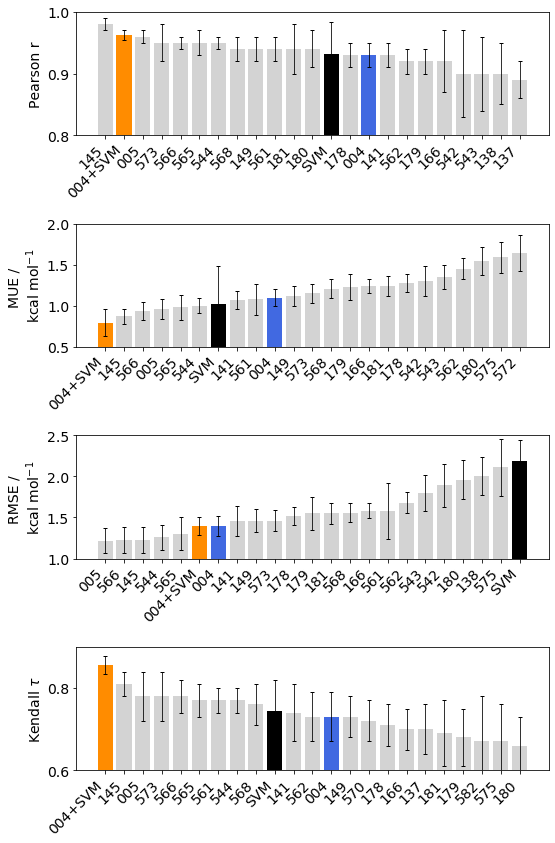

In [16]:

########################################
# construct the graph:
fig, axes = plt.subplots(4, 1, figsize=[8, 12])
num_entries_to_show = 23
plt.rcParams.update({'font.size': 16})

for ax, metric in zip(axes, ["R", "AUE", "RMS", "tau"]):
    # first, select the right subplot:

    
    # the four metrics require different formatting:
    if metric == "AUE":
        # grab the data for this metric and sort:
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=True)
        # grab the uncertainties:
        metric_data_uncertainties = metric_data_sorted["error2"].head(num_entries_to_show).values
        # change the title:
        title = "MUE / \nkcal mol$^{-1}$"
        ax.set_ylim(0.5,2)
    if metric == "RMS":
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=True)
        metric_data_uncertainties = metric_data_sorted["error1"].head(num_entries_to_show).values
        title = "RMSE / \nkcal mol$^{-1}$"
        ax.set_ylim(1,2.5)
    if metric == "tau":
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=False)
        metric_data_uncertainties = metric_data_sorted["error3"].head(num_entries_to_show).values
        title = r"Kendall $\tau$"
        ax.set_ylim(0.6,0.9)
    if metric == "R":
        metric_data_sorted = sampl4_df.sort_values(by=metric, ascending=False)
        metric_data_uncertainties = metric_data_sorted["error4"].head(num_entries_to_show).values
        title = "Pearson r"
        ax.set_ylim(0.8,1)
    
    # extract the actual datapoints we need and their index names (i.e. entries):
    metric_data_values = metric_data_sorted[metric].head(num_entries_to_show).values
    metric_data_indices = metric_data_sorted.head(num_entries_to_show).index.tolist()
    

    # set bar colours:
    index_colours = []
    for entry in metric_data_indices:
            
        if entry == "004+SVM":
            index_colours.append("darkorange")
        elif entry == "SVM":
            index_colours.append("black")
        elif entry == "004":
            index_colours.append("royalblue")

            
        # make all other SAMPL4 entries grey:
        else:
            index_colours.append("lightgrey")

    # make the bars + uncertainties:
    ax.bar(
                x=metric_data_indices, 
                height=metric_data_values, 
                color=index_colours
            )
    ax.errorbar(x=metric_data_indices, y=metric_data_values, yerr=metric_data_uncertainties, 
                fmt="none", capsize=2, lw=0.8, zorder=200, color="black")
    
    
    # some general formatting:
    ax.set_xticklabels(labels=metric_data_indices, rotation=45, ha="right")
    ax.set_ylabel(title)
    for label in (ax.get_xticklabels()):
        label.set_fontsize(14)

        
# fep_patch = mpatches.Patch(color='black', label='Pure FEP')

# hyb_patch = mpatches.Patch(color='lightblue', label='ML+FEP Hybrid')
# null_path = mpatches.Patch(color='darkorange', label='Pure ML')

# # hyb_NO_patch = mpatches.Patch(color='lightblue', label='ML+FEP Hybrid*')
# # null_NO_path = mpatches.Patch(color='navy', label='Null (ML)*')

# axes[0][0].legend(handles=[fep_patch, hyb_patch, null_path], 
#            fontsize="large", loc="upper left")



plt.tight_layout()
plt.savefig("OUTPUTS/sampl4_barplots.png", dpi=300)

In [17]:
sampl4_df

,Avg. err.,error,RMS,error1,AUE,error2,tau,error3,R,error4,Err. slope,error5,Max. err.,error6
004,0.13,0.13,1.400000,0.120000,1.100000,0.100000,0.730000,0.060000,0.930000,0.020000,0.99,0.07,4.98,0.47
005,-0.42,0.18,1.220000,0.150000,0.960000,0.120000,0.780000,0.060000,0.960000,0.010000,1.06,0.05,1.81,0.67
014,1.11,0.57,3.070000,0.720000,1.900000,0.510000,0.360000,0.150000,0.710000,0.260000,1.01,0.10,10.69,0.70
015,1.02,0.49,3.090000,0.460000,2.020000,0.340000,0.360000,0.090000,0.650000,0.200000,1.00,0.07,10.37,0.42
137,2.24,0.23,2.890000,0.300000,2.480000,0.200000,0.700000,0.060000,0.890000,0.030000,0.70,0.08,8.38,0.50
138,0.51,0.29,2.000000,0.230000,1.660000,0.200000,0.650000,0.060000,0.900000,0.050000,0.57,0.08,5.25,0.23
141,-0.07,0.28,1.460000,0.180000,1.070000,0.110000,0.740000,0.070000,0.930000,0.020000,0.72,0.08,6.02,0.46
145,-0.44,0.16,1.230000,0.160000,0.870000,0.090000,0.810000,0.030000,0.980000,0.010000,0.86,0.08,1.24,0.89
149,0.03,0.24,1.460000,0.140000,1.120000,0.120000,0.730000,0.050000,0.940000,0.020000,0.55,0.04,2.74,0.89
152,-3.48,0.98,5.520000,1.250000,4.050000,0.850000,0.390000,0.080000,0.570000,0.170000,0.31,0.06,3.93,3.84


## Apply correction term to all published SAMPL4 entries

In [18]:
svm_hybrid_predictions = top_performers_collection[0][2][0]

fep_predictions = test_calc.values
smiles_per_freesolv_entry = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie','SMILES']

svm_offset_predictions = (svm_hybrid_predictions-fep_predictions).tolist()

freesolv_ids = pd.DataFrame({
    "FREESOLV_ID" : test_calc.index,
    "offset_pred" : svm_offset_predictions,
    "dG_exp" : test_exp.values,
    "SMILES" : smiles_per_freesolv_entry.values
}).set_index("SMILES")

sampl4_ids = pd.read_csv("datasets/backend/title_vs_smiles_sampl4.txt", header=None, sep="    ", engine='python')
sampl4_ids.columns = ["SAMPL4_ID", "SMILES"]
sampl4_ids = sampl4_ids.set_index("SMILES")

corrector_df = pd.concat([sampl4_ids, freesolv_ids], axis=1, sort=True).dropna().reset_index().drop("index", axis=1)
corrector_df = corrector_df.set_index("SAMPL4_ID")

In [19]:
# now generate an iterable for all sampl4 submissions:
submissions_path = "./datasets/backend/sampl4_submissions/"
submissions_dir = glob.glob(submissions_path+"*")
# clean file names:
submissions_dir = [file.replace(submissions_path, "") for file in submissions_dir]
# take only the .data files:
submissions_dir = [file for file in submissions_dir if file.endswith(".data")]

# loop over submissions, compute statistics with and without correcting:
processed_entries = []

# read per file:
stats_collection = []
entry_names_collection = []
for filepath in submissions_dir:
    entry_name = filepath.split(".")[0]
    if not entry_name == "580":    # this entry only has 11 computed energies; discard.
        
        entry_df = pd.read_csv(submissions_path+filepath, comment="#", header=None, usecols=[0,1])
        entry_df.columns = ["SAMPL4_ID", "FE_pred"]
        entry_df = entry_df.set_index("SAMPL4_ID")

        # construct a dataframe with the respective corrections:
        collected_df = pd.concat([corrector_df, entry_df], axis=1, sort=True).dropna()

        # compute the hybrid predictions for this entry:
        collected_df["FE_hyb"] = collected_df["FE_pred"] + collected_df["offset_pred"] 
        
        # now compute stats for standalone and hybridised version of this entry:
        stats_standalone = compute_stats( collected_df["FE_pred"],  collected_df["dG_exp"])
        stats_hybrid = compute_stats(collected_df["FE_hyb"],  collected_df["dG_exp"])
 
        stats_improvements_this_entry = list(zip(stats_hybrid, stats_standalone))
        stats_collection.append(stats_improvements_this_entry)
        entry_names_collection.append(entry_name)
        # if we need revert back to % gain per statistic, compute % gain here and skip next code block.

In [70]:
# using this data, compute original ranking per metric and number of ranks gained (or lost) by correction:
def compute_hybrid_rank_gain(statistic_dataframe, error_metric):
    """
    computes both the standalone SAMPL4 rank for this statistic as well as the hybrid rank when inserted into
    the standalone entries.
    """
    records_df = pd.DataFrame.from_records(statistic_dataframe, columns=["hybrid", "standalone"])
    records_df["entry_name"] = entry_names_collection
    records_df = records_df.sort_values(by="standalone", ascending=error_metric).reset_index()

    # compute standalone ranking:
    records_df["standalone_rank"] = records_df.index.values + 1

    # compute hybrid ranking:

    hybrid_ranks = []
    for idx, row in records_df.iterrows():
        hybrid_value = row["hybrid"]
        entry_name = row["entry_name"]
        # now figure out at what rank this hybrid statistic would place in the standalone ranking:
        # drop the standalone entry:
        inserted_df = records_df.loc[records_df["entry_name"] != entry_name]


        inserted_df = inserted_df.append({"entry_name" : "insert",
                                "standalone" : hybrid_value}, ignore_index=True).sort_values(
                                    by="standalone", ascending=error_metric).reset_index()
        hybrid_rank = inserted_df.loc[inserted_df["entry_name"] == "insert"].index.values + 1


        hybrid_ranks.append(int(hybrid_rank))

    records_df["hybrid_rank"] = hybrid_ranks
    records_df["rank_gain"] = records_df["standalone_rank"] - records_df["hybrid_rank"]
    records_df = records_df.set_index("entry_name")

    return records_df["rank_gain"], records_df["standalone_rank"]


r_vals = [entry_data[0] for entry_data in stats_collection]
r_gains, r_ranks = compute_hybrid_rank_gain(r_vals, error_metric=False)

mue_vals = [entry_data[1] for entry_data in stats_collection]
mue_gains, mue_ranks = compute_hybrid_rank_gain(mue_vals, error_metric=True)

rmse_vals = [entry_data[2] for entry_data in stats_collection]
rmse_gains, rmse_ranks = compute_hybrid_rank_gain(rmse_vals, error_metric=True)

rho_vals = [entry_data[3] for entry_data in stats_collection]
rho_gains, rho_ranks = compute_hybrid_rank_gain(rho_vals, error_metric=False)

tau_vals = [entry_data[4] for entry_data in stats_collection]
tau_gains, tau_ranks = compute_hybrid_rank_gain(tau_vals, error_metric=False)

all_stats_gains_df = pd.concat([r_gains, mue_gains, rmse_gains, rho_gains, tau_gains,
                               r_ranks, mue_ranks, rmse_ranks, rho_ranks, tau_ranks], axis=1) 
all_stats_gains_df.columns =[ "r_improvement",
                        "mue_improvement", 
                        "rmse_improvement", 
                        "rho_improvement", 
                        "tau_improvement",
                         "r_ranks",
                        "mue_ranks", 
                        "rmse_ranks", 
                        "rho_ranks", 
                        "tau_ranks",
                        ]
all_stats_gains_df["aggregate"] = all_stats_gains_df["r_improvement"] + all_stats_gains_df["mue_improvement"] + all_stats_gains_df["tau_improvement"]
all_stats_gains_df["aggregate_original"] = all_stats_gains_df["r_ranks"] + all_stats_gains_df["mue_ranks"] + all_stats_gains_df["tau_ranks"]

# compute ranks before and after hybridisation:
all_stats_gains_df["r_before"] = all_stats_gains_df["r_ranks"]
all_stats_gains_df["r_after"] = all_stats_gains_df["r_ranks"] - all_stats_gains_df["r_improvement"]

all_stats_gains_df["mue_before"] = all_stats_gains_df["mue_ranks"]
all_stats_gains_df["mue_after"] = all_stats_gains_df["mue_ranks"] - all_stats_gains_df["mue_improvement"]

all_stats_gains_df["rmse_before"] = all_stats_gains_df["rmse_ranks"]
all_stats_gains_df["rmse_after"] = all_stats_gains_df["rmse_ranks"] - all_stats_gains_df["rmse_improvement"]

all_stats_gains_df["tau_before"] = all_stats_gains_df["tau_ranks"]
all_stats_gains_df["tau_after"] = all_stats_gains_df["tau_ranks"] - all_stats_gains_df["tau_improvement"]

# now drop all redundant columns:
cols_to_drop = ["r_improvement", "mue_improvement", "rmse_improvement", "rho_improvement", "tau_improvement", "r_ranks", "mue_ranks", "rmse_ranks", "rho_ranks", "tau_ranks"]

for col_name in cols_to_drop:
    all_stats_gains_df.drop(col_name, inplace=True, axis=1)

all_stats_gains_df

/home/jscheen/miniconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,aggregate,aggregate_original,r_before,r_after,mue_before,mue_after,rmse_before,rmse_after,tau_before,tau_after
004,36,40,16,2,11,1,9,1,13,1
005,-7,7,2,2,3,10,1,9,2,2
006,11,17,7,2,5,2,3,1,5,2
014,-3,131,43,43,38,41,39,41,50,50
015,4,133,44,44,40,36,40,41,49,49
137,21,89,27,17,42,41,37,32,20,10
138,3,84,24,24,28,31,24,26,32,26
141,-10,42,18,17,9,12,13,10,15,23
145,-36,4,1,11,2,20,5,24,1,9
149,-9,36,12,16,12,17,11,23,12,12


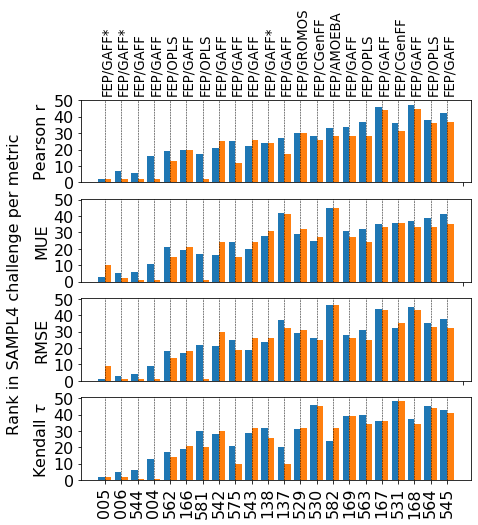

In [171]:
# append information and plot:

sampl4_entries_hybrids = all_stats_gains_df
sampl4_entry_info_records = pd.read_csv("./datasets/backend/sampl4_entries_info.csv", dtype={'Entry': object}).set_index("Entry")
sampl4_entry_info_records = sampl4_entry_info_records["LABEL"]
sampl4_entries_hybrids_unsorted = pd.concat([sampl4_entries_hybrids, sampl4_entry_info_records], axis=1, sort=False).dropna()

# now set up data: we want all FEP entries and the top non-FEP entries:
sampl4_entries_fep = sampl4_entries_hybrids_unsorted[sampl4_entries_hybrids_unsorted["LABEL"].str.contains("FEP")]
sampl4_entries_fep = sampl4_entries_fep.sort_values(by="aggregate_original", ascending=True)

sampl4_entries_top_nonfep = sampl4_entries_hybrids_unsorted[~sampl4_entries_hybrids_unsorted["LABEL"].str.contains("FEP")]
sampl4_entries_top_nonfep = sampl4_entries_top_nonfep.sort_values(by="aggregate_original", ascending=True)


fig, axes = plt.subplots(4, 1, sharey=True, figsize=(7,7))
x_values_fep = sampl4_entries_fep.index.values
x_values_top_nonfep = sampl4_entries_top_nonfep.index.values

bar_width=0.4


axes[0].bar(x_values_fep, sampl4_entries_fep["r_before"], width=-bar_width, align="edge")
axes[0].bar(x_values_fep, sampl4_entries_fep["r_after"], width=bar_width, align="edge")
axes[0].set_xticks("")
axes[0].set_ylabel("Pearson r")

axes[1].bar(x_values_fep, sampl4_entries_fep["mue_before"], width=-bar_width, align="edge")
axes[1].bar(x_values_fep, sampl4_entries_fep["mue_after"], width=bar_width, align="edge")
axes[1].set_xticks("")
axes[1].set_ylabel("MUE")

axes[2].bar(x_values_fep, sampl4_entries_fep["rmse_before"], width=-bar_width, align="edge")
axes[2].bar(x_values_fep, sampl4_entries_fep["rmse_after"], width=bar_width, align="edge")
axes[2].set_xticks("")
axes[2].set_ylabel("RMSE")

axes[3].bar(x_values_fep, sampl4_entries_fep["tau_before"], width=-bar_width, align="edge")
axes[3].bar(x_values_fep, sampl4_entries_fep["tau_after"], width=bar_width, align="edge")
axes[3].set_xticklabels(labels=x_values_fep, rotation=90)
axes[3].set_ylabel(r"Kendall $\tau$")

for ax in axes:
    for x_val in x_values_fep:
        ax.axvline(x_val, color="black", ls="--", lw=0.5)

# now include top tags with methods:

for entry, info in zip(range(len(x_values_fep)), sampl4_entries_fep["LABEL"].values):
    axes[0].text(x=entry-0.3, y=55, s=info, ha="left", rotation=90, size="small")


plt.locator_params(axis='y', nbins=6)
plt.text(s="Rank in SAMPL4 challenge per metric", x=-6, y=30, rotation=90)
plt.savefig("OUTPUTS/translatability_sampl4_barplot.png", dpi=300, bbox_inches="tight")

plt.show()

    


Now generate the same plot but for non-FEP entries

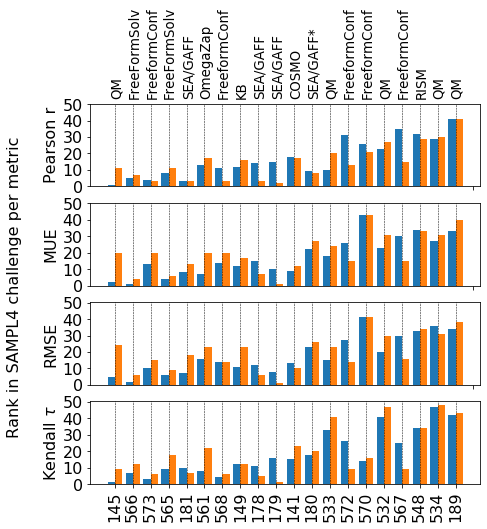

In [174]:
# take only top n entries:
sampl4_entries_top_nonfep = sampl4_entries_top_nonfep.head(20)

fig, axes = plt.subplots(4, 1, sharey=True, figsize=(7,7))
x_values_fep = sampl4_entries_fep.index.values
x_values_top_nonfep = sampl4_entries_top_nonfep.index.values

bar_width=0.4


axes[0].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["r_before"], width=-bar_width, align="edge")
axes[0].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["r_after"], width=bar_width, align="edge")
axes[0].set_xticks("")
axes[0].set_ylabel("Pearson r")

axes[1].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["mue_before"], width=-bar_width, align="edge")
axes[1].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["mue_after"], width=bar_width, align="edge")
axes[1].set_xticks("")
axes[1].set_ylabel("MUE")

axes[2].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["rmse_before"], width=-bar_width, align="edge")
axes[2].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["rmse_after"], width=bar_width, align="edge")
axes[2].set_xticks("")
axes[2].set_ylabel("RMSE")

axes[3].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["tau_before"], width=-bar_width, align="edge")
axes[3].bar(x_values_top_nonfep, sampl4_entries_top_nonfep["tau_after"], width=bar_width, align="edge")
axes[3].set_xticklabels(labels=x_values_top_nonfep, rotation=90)
axes[3].set_ylabel(r"Kendall $\tau$")

for ax in axes:
    for x_val in x_values_top_nonfep:
        ax.axvline(x_val, color="black", ls="--", lw=0.5)

# now include top tags with methods:

for entry, info in zip(range(len(x_values_top_nonfep)), sampl4_entries_top_nonfep["LABEL"].values):
    axes[0].text(x=entry-0.3, y=55, s=info, ha="left", rotation=90, size="small")


plt.locator_params(axis='y', nbins=6)
plt.text(s="Rank in SAMPL4 challenge per metric", x=-6, y=30, rotation=90)
plt.savefig("OUTPUTS/translatability_nonfep_sampl4_barplot.png", dpi=300, bbox_inches="tight")

plt.show()